In [64]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.covariance import EmpiricalCovariance, EllipticEnvelope, MinCovDet
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.svm import OneClassSVM

# saving models
from sklearn.externals import joblib

# incase we want to try some cleaning steps to see if it improves the model
import Clean_Function_Helpers as cfh

In [66]:
if not os.path.isdir('saved_models/'):
    os.mkdir('saved_models')
if not os.path.isdir('saved_models/regular/'):
    os.mkdir('saved_models/regular/')
if not os.path.isdir('saved_models/undersampled/'):
    os.mkdir('saved_models/undersampled/')
if not os.path.isdir('saved_models/oversampled/'):
    os.mkdir('saved_models/oversampled/')

In [2]:
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

SEED = 1111

In [3]:
# helper functions
def get_weights(ser):
    """
    Weighs observations so that they can be
    sampled in such a way as to result in even distributions.
    Used in following function to oversample minority class of a dataset.
    """
    vcs = ser.value_counts()
    class_labels = vcs.index.tolist()
    class_sizes = vcs.values
    nclasses = len(class_labels)
    class_weights = dict(zip(class_labels,(nclasses**-1/class_sizes)))
    return class_weights


def pr_curve(y_actual, y_pred, digit_prec=2):
    '''
    PLOTS THE PRECISION VS RECAL OF A LOG REG ESTIMATOR
    OVER A RANGE OF THRESHOLDS

    Y_PRED MUST BE PREDICTED PROBABILITY VECTOR OF ONE CLASS (EG PROBS[:,1])
    MUST ALL BE OF TYPE INT OR FLOAT

    RETURNS: recalls, precisions, thresholds

    '''
    threshvec = np.unique(np.round(y_pred,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(y_actual[y_pred>=thresh])
        fpvec[i] = sum(1-y_actual[y_pred>=thresh])
        fnvec[i] = sum(y_actual[y_pred<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    return (recallvec, precisionvec, threshvec)

def calc_f1(recalls, precisions):
    return (2*recalls*precisions)/(recalls + precisions)

## Overview

Taking two different approaches. 

    1. Try to model the difference between real and fraudulent charges.
        - Classifiers like Logistic Regression, NaiveBayes, Tree Ensembles etc
        - Sampling approaches over vs undersampling
    2. Try to identify core boundary of real charges and identify anything outside this boundary as fraudulent.
        - Covariance estimates, Local Outlier Factor, Clustering, One Class SVM
        
This notebook focuses on the first approach: using classification algorithms to predict fraudulent charges.

### Read Data

In [4]:
df = pd.read_csv('creditcard.csv')
df.Class.value_counts()/df.Class.value_counts().sum()

0    0.998273
1    0.001727
Name: Class, dtype: float64

### Classifiers

Here we cross-validate a few classifiers on the raw data via the following steps:

    1. Take a small sample of the data set for training. This both reduces training time and gives us a large test set for validation. Make sure the Class proportions are the same in the sample as the test dataset.
        * Note that the training set has only about 100 fraudulent cases in it.
    2. Fit a classifier using Cross-validated grid search on the training set.
    3. Use the final estimator to make predictions on the test set and calculate precision and recall.

In [54]:
def get_sample(df, n=None, frac=None, n_oversample=False, n_undersample=False):
    """
    Generate Train and Test samples of specified size with the option
    to oversample or undersample.
    """
    if n_oversample:
        # split out classes
        c0 = df[df.Class==0].sample(n = n_oversample//2, random_state = SEED)
        # sample half of the minority class
        c1 = df[df.Class==1].sample(frac=0.5, random_state = SEED)
        # sample the minority class W REPLACEMENT
        c1 = c1.sample(n_oversample//2, replace=True, random_state=SEED)
        # join them together
        train = pd.concat([c0,c1])
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    elif n_undersample:
        # take `n_undersample` observations from each class
        idx0 = df[df.Class==0].sample(n = n_undersample, random_state = SEED).index.tolist()
        idx1 = df[df.Class==1].sample(n = n_undersample, random_state = SEED).index.tolist()
        tidx = idx0 + idx1
        train = df.loc[tidx].copy() 
        test = df[~df.index.isin(tidx)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    else:
        train = df.sample(n=n, frac=frac, random_state=SEED)
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test

def evaluate_classifier(train_data, test_data, clf, params, cv=4, scoring='roc_auc'):
    '''
    Takes grid searches parameters for a passed classifier and evaluates 
    on the test set.
    '''
    x = train_data.drop(['Time','Class'], axis=1)
    y = train_data.Class

    # grid search parameters
    grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(x,y)
    print('Best Params:', grid.best_params_)
    print('Best Score:', grid.best_score_)

    # get best estimator and scores
    mod = grid.best_estimator_
    # run predictions on test set
    pred_proba = mod.predict_proba(test_data[x.columns])
    preds = mod.predict(test_data[x.columns])
    
    # plot pr curve
    r,p,t = pr_curve(test_data.Class, pred_proba[:,1]);
    
    # find threshold that maximizes f1 score
    idx = np.argmax(calc_f1(r[:-1],p[:-1]))
    stats = {
        'auc': grid.best_score_,
        'f1': calc_f1(r[idx], p[idx]),
        'recall': r[idx],
        'precision': p[idx],
        'threshold': t[idx]
    }
    print('F1:', calc_f1(r[idx], p[idx]))
    print('Recall:', r[idx])
    print('Precision:', p[idx])
    print('Threshold:', t[idx])
    return mod, x, y, stats

In [45]:
# We will test different transforms of the data

sub_cols = df.columns.drop(['Time', 'Class'])

scaled_df = cfh.scale_data(df, MinMaxScaler(), sub_cols)
deskewed = cfh.deskew_df(scaled_df, topn=10)
no_ol = cfh.remove_outliers(scaled_df, S=5, subset_rows=df.Class==0, subset_cols=sub_cols)
deskewed_no_ol = cfh.remove_outliers(deskewed, S=5, subset_rows=df.Class==0, subset_cols=sub_cols)
no_ol_deskewed = cfh.deskew_df(no_ol, topn=10)

In [47]:
# Parameters for grid search
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]}

priors = [(p, 1-p) for p in np.arange(0.1, 1, 0.1)]
nb_params = {'priors': priors}


class_weights = [{0:p, 1:1-p} for p in [0.1, 0.25, 0.5, 0.75, 0.9]]
tree_params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
    'class_weight': class_weights
}


In [ ]:
results = {}

In [ ]:
for data_transformed, transform_label in zip(
    [df, scaled_df, deskewed, no_ol, deskewed_no_ol, no_ol_deskewed],
    ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers', 'No Outliers - De-Skewed']
):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED)
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        train_reg, test_reg = get_sample(data_transformed, frac=0.2)
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_reg, test_reg, clf, params)
        plt.title(label)
        results[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [ ]:
# Save Results
for k, (mod,x,y,stats) in results.items():
    joblib.dump(mod, 'saved_models/regular/'+k+'.joblib')
    with open('saved_models/regular/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

We see that all classifiers acheive a high AUC score on the data. However,
the Naive Bayes classifier suffers from it's simplicity and has very low precision on the target class (fraudulent).

Th Random Forest and Extra Trees Classifiers perform about equally and achieve a higher F1 score than the Logistic Regression.

--------------

### Sampling

We are going to perform the same steps as above except we are going to use both over and undersampling techniques
to create a training dataset.

For undersampling, we are going to create a very small training set where the distribution of classes is equal in the training set.

For oversampling, we will duplicate observations in the minority class (possibly with added gaussian noise) until the sampling distribution is equal.


___Undersample Majority___

In [48]:
del tree_params['class_weight']

In [49]:
results_us = {}

EVALUATING: Regular -- LogisticRegression

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.986883768561188
F1: 0.5816326530612246
Recall: 0.7066115702479339
Precision: 0.49421965317919075
Threshold: 0.99

EVALUATING: Regular -- GaussianNB

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9584198668714798
F1: 0.05535690637001722
Recall: 0.8636363636363636
Precision: 0.028594883020933097
Threshold: 0.99

EVALUATING: Regular -- RandomForestClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150}
Best Score: 0.9850506912442397
F1: 0.7430997876857749
Recall: 0.7231404958677686
Precision: 0.7641921397379913
Threshold: 0.96

EVALUATING: Regular -- ExtraTreesClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Best Score: 0.987031233998976
F1: 0.7106796116504853
Recall: 0.756198347107438
Precision: 0.6703296703296703
Threshold: 0.92

EVALUATING: Scaled -- LogisticRegression

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'C': 10, 'penalty': 'l1'}
Best Score: 0.9834

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9625908858166922
F1: 0.05541358439811701
Recall: 0.8512396694214877
Precision: 0.02863895453913527
Threshold: 0.99

EVALUATING: No Outliers -- RandomForestClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.9826656426011263
F1: 0.8683602771362586
Recall: 0.7768595041322314
Precision: 0.9842931937172775
Threshold: 0.91

EVALUATING: No Outliers -- ExtraTreesClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 50}
Best Score: 0.9861618023553508
F1: 0.8727272727272728
Recall: 0.7933884297520661
Precision: 0.9696969696969697
Threshold: 0.88

EVALUATING: De-Skewed - No Outliers -- LogisticRegression

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64

Best Params: {'C': 10, 'penal

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.962247823860727
F1: 0.08751823296520109
Recall: 0.8677685950413223
Precision: 0.04608294930875576
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- RandomForestClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9809825908858167
F1: 0.8598130841121494
Recall: 0.7603305785123967
Precision: 0.989247311827957
Threshold: 0.91

EVALUATING: De-Skewed - No Outliers -- ExtraTreesClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}
Best Score: 0.9820573476702508
F1: 0.8649885583524026
Recall: 0.78099173553719
Precision: 0.9692307692307692
Threshold: 0.88

EVALUATING: No Outliers - De-Skewed -- LogisticRegression

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: in

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'C': 10, 'penalty': 'l1'}
Best Score: 0.9792974910394266
F1: 0.8584905660377359
Recall: 0.7520661157024794
Precision: 1.0
Threshold: 0.99

EVALUATING: No Outliers - De-Skewed -- GaussianNB

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9626533538146441
F1: 0.06353161009031455
Recall: 0.8429752066115702
Precision: 0.03300970873786408
Threshold: 0.99

EVALUATING: No Outliers - De-Skewed -- RandomForestClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.9826656426011263
F1: 0.8657407407407407
Recall: 0.7727272727272727
Precision: 0.9842105263157894
Threshold: 0.91

EVALUATING: No Outliers - De-Skewed -- ExtraTreesClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 150}
Best Score: 0.9842877624167946
F1: 0.8657407407407407
Recall: 0.7727272727272727
Precision: 0.9842105263157894
Threshold: 0.92



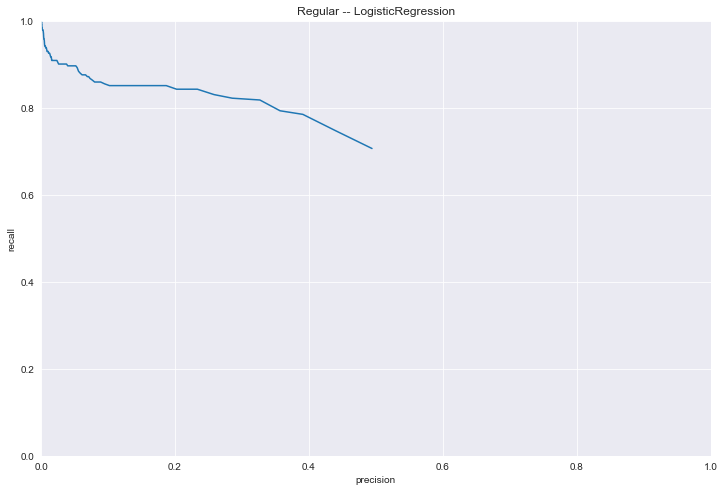

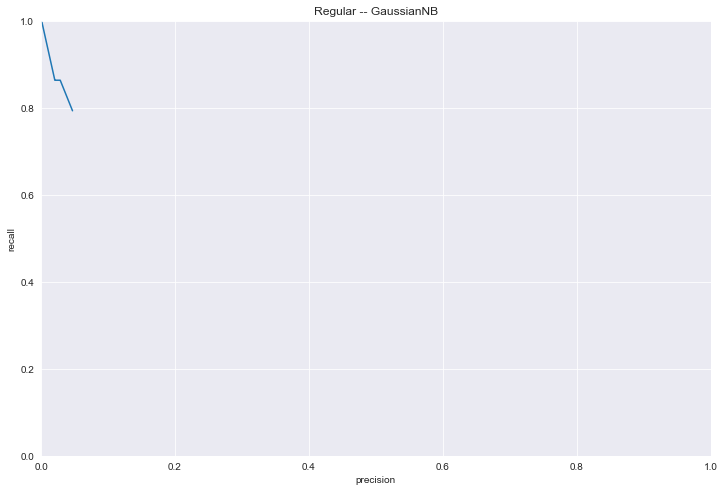

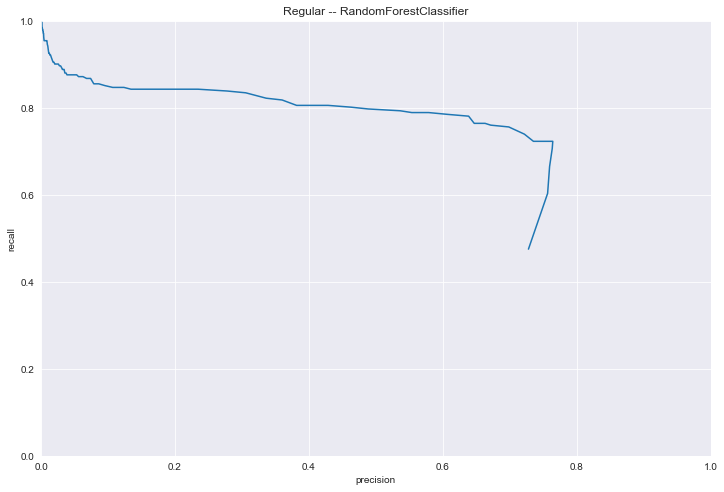

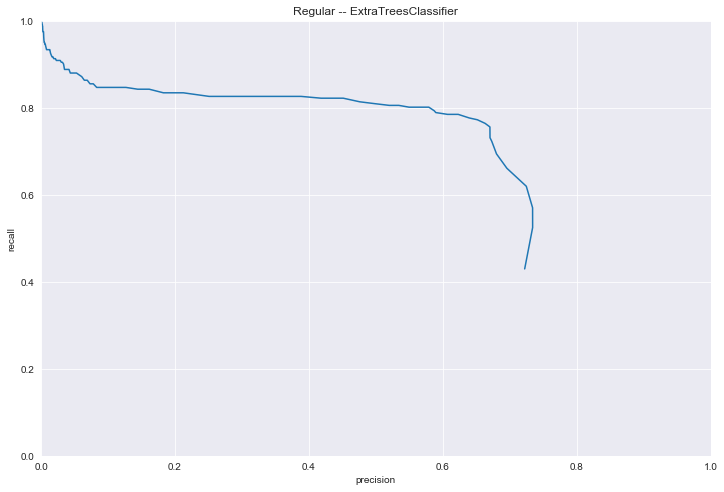

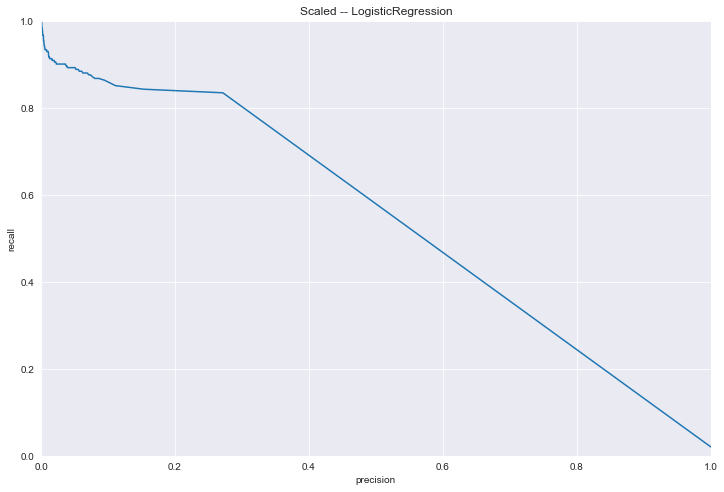

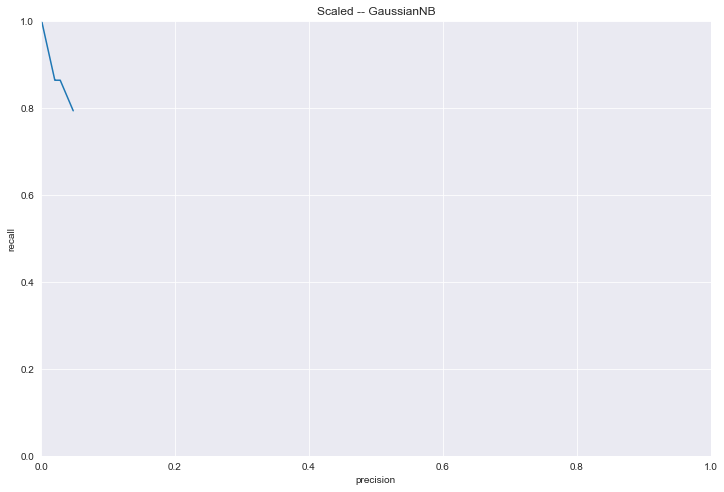

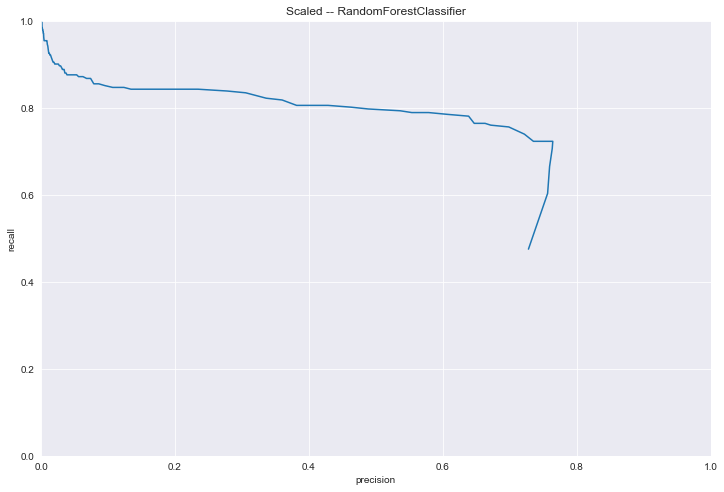

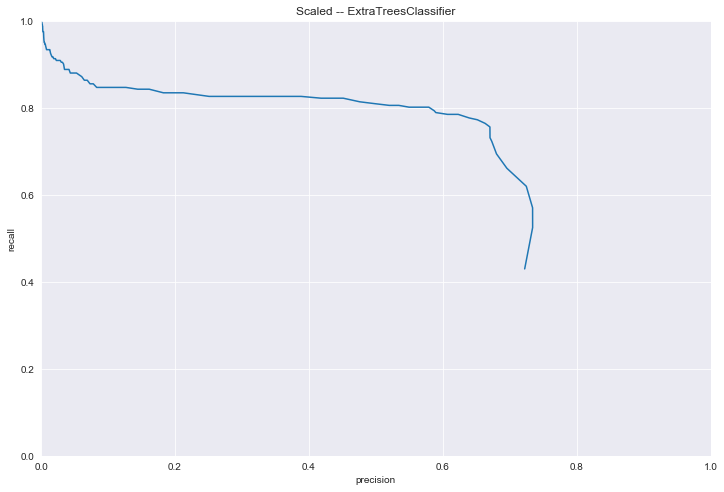

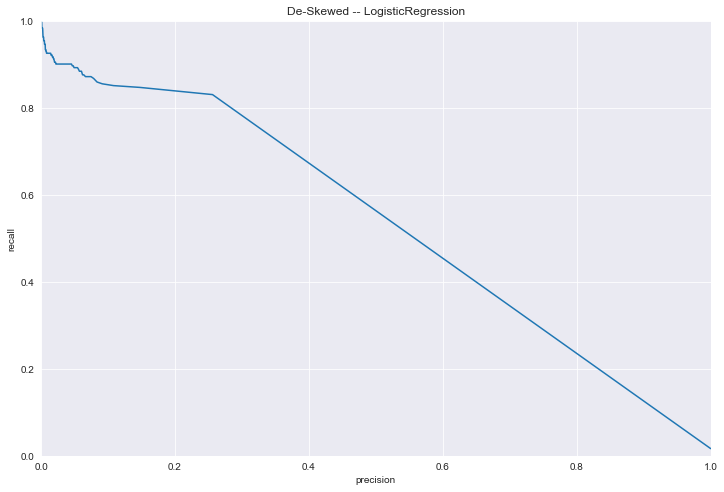

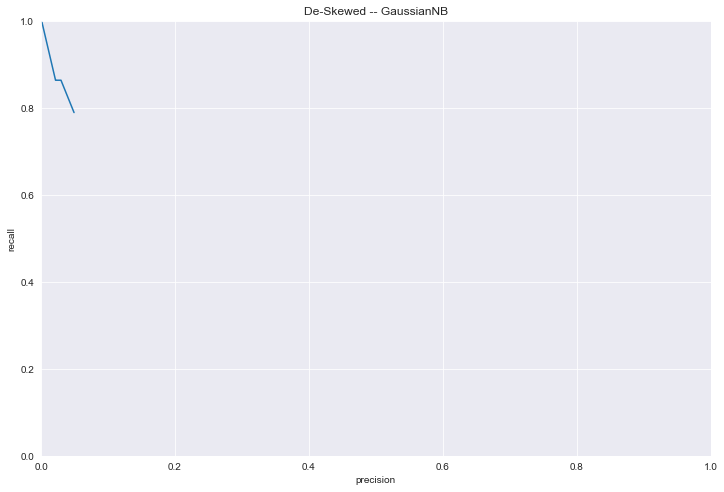

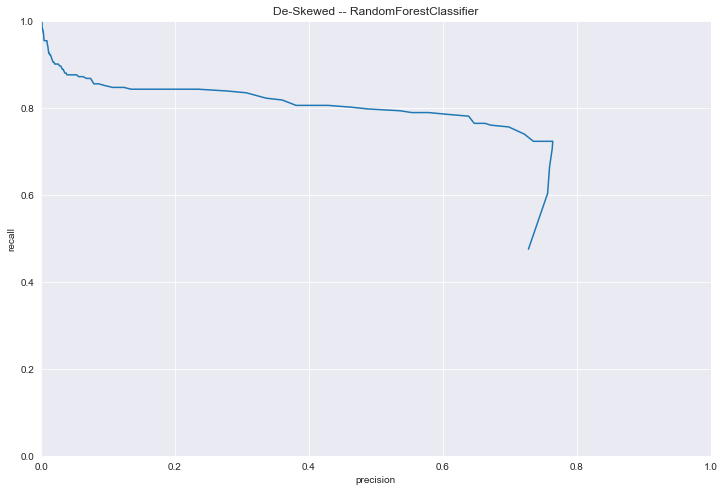

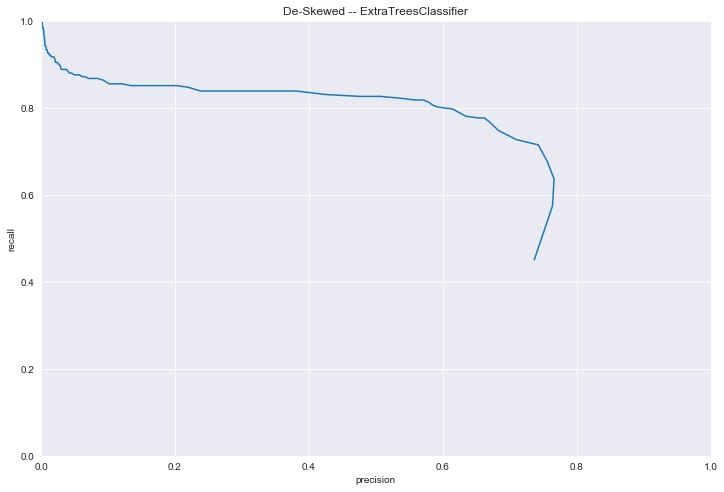

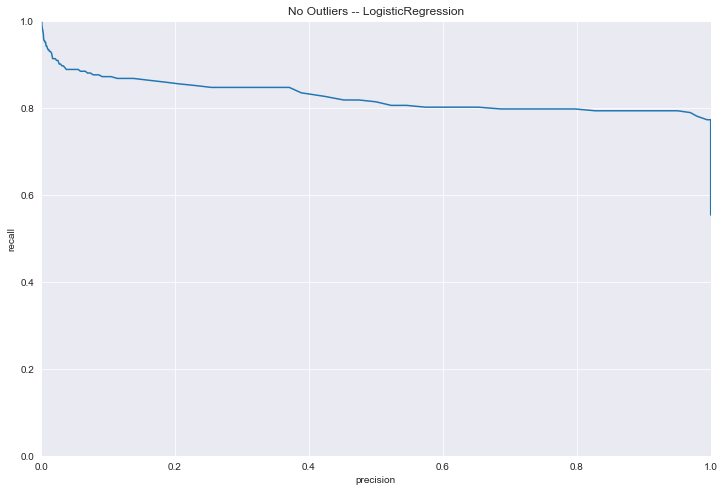

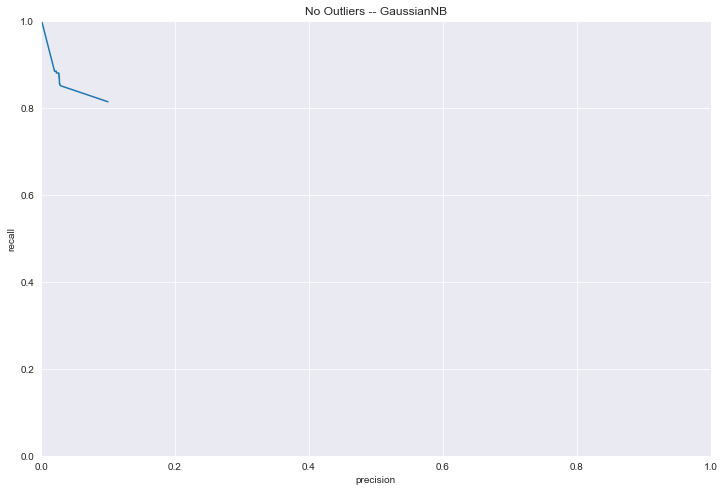

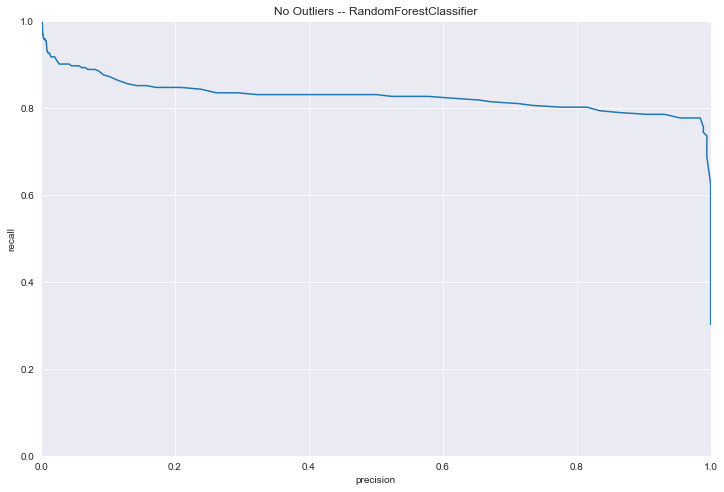

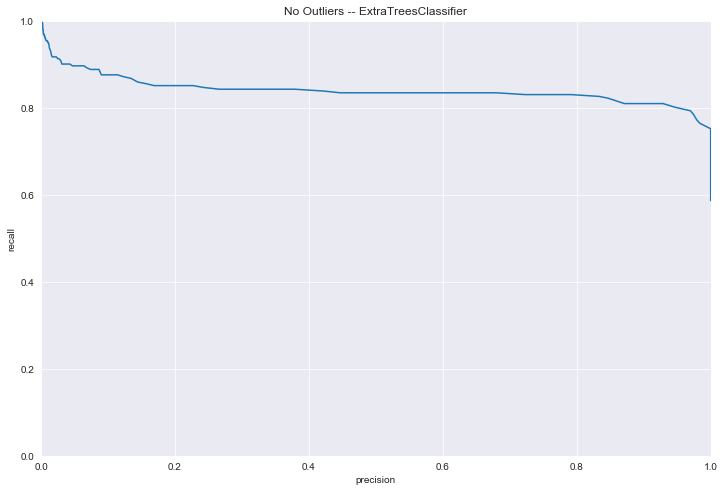

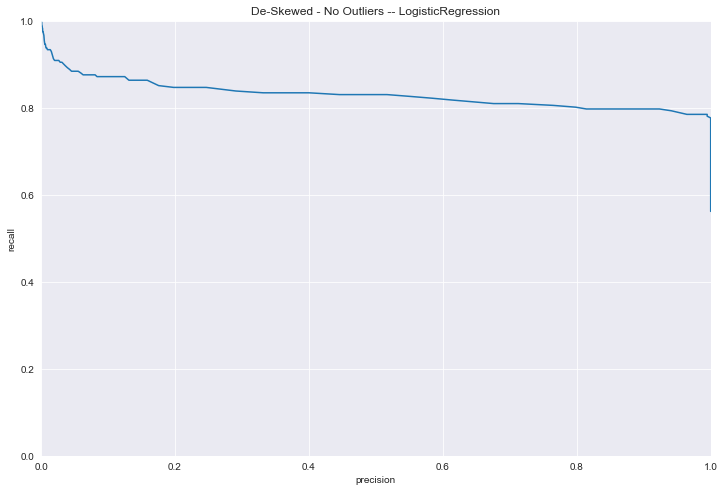

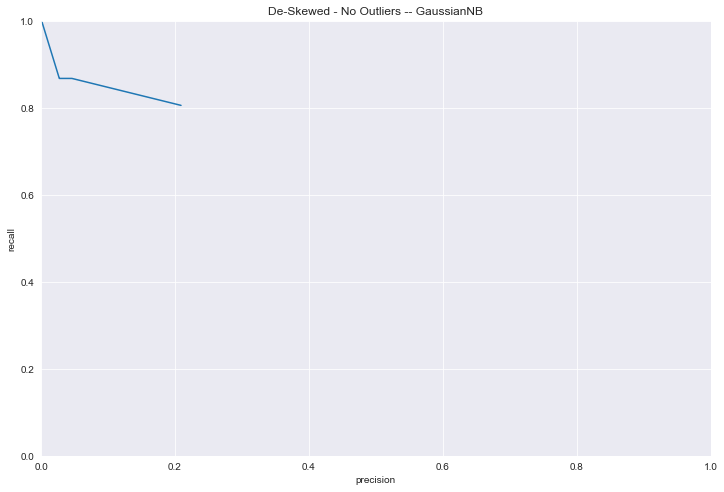

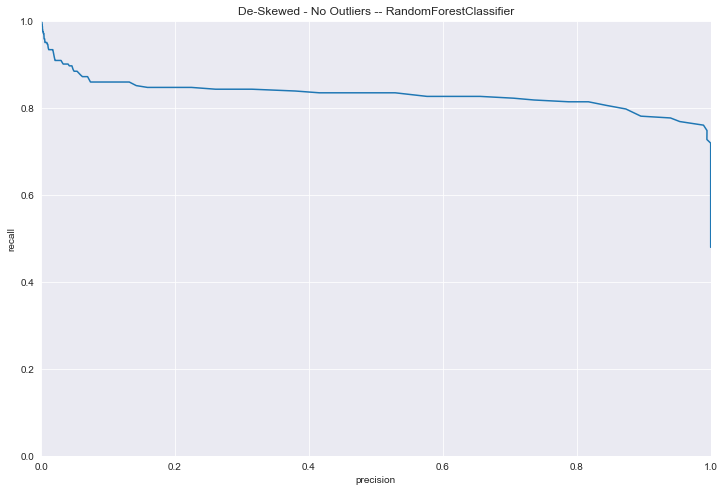

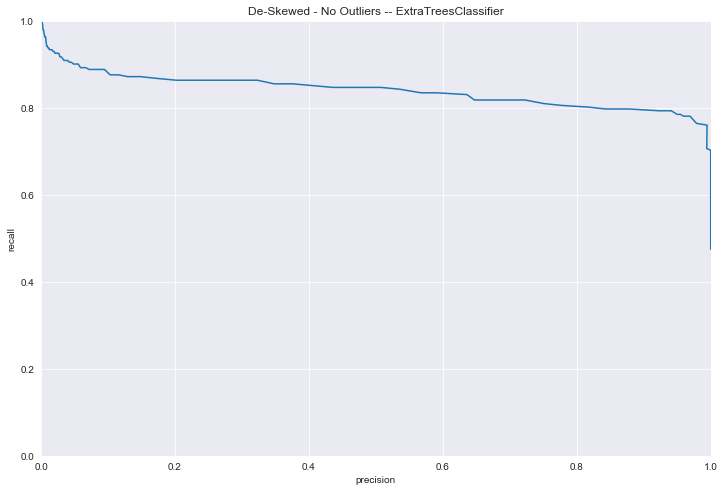

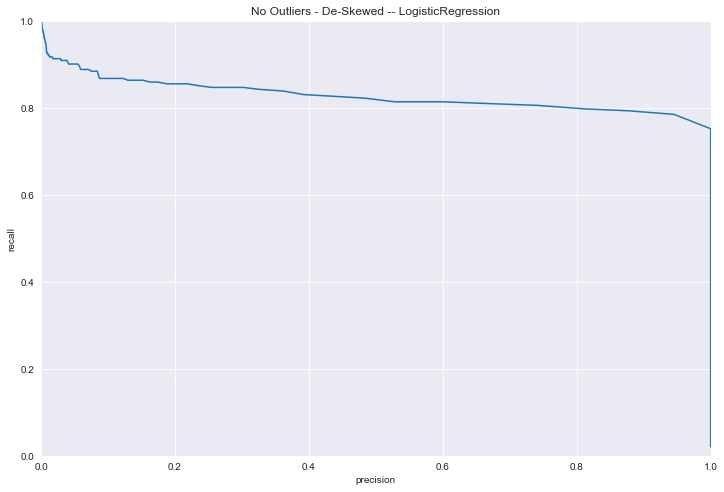

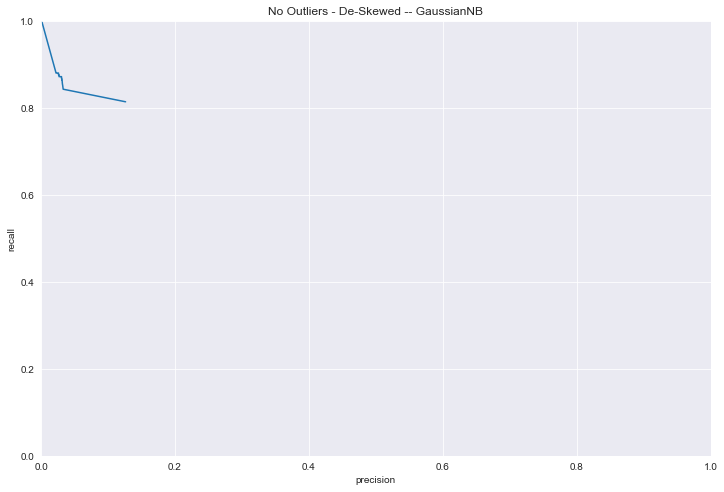

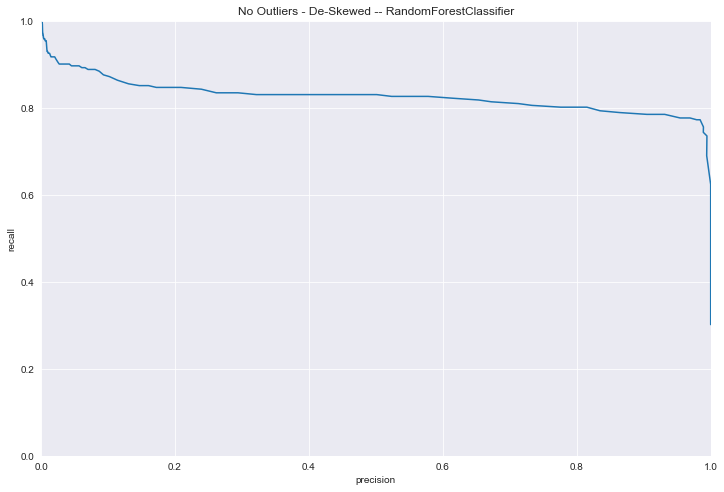

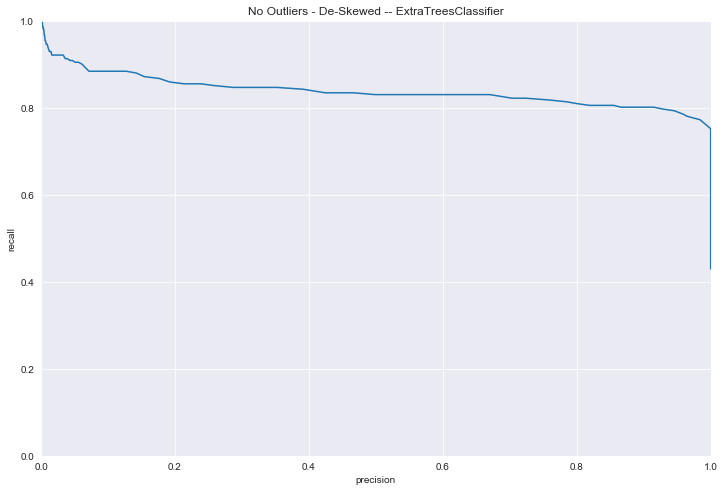

In [55]:
for data_transformed, transform_label in zip(
    [df, scaled_df, deskewed, no_ol, deskewed_no_ol, no_ol_deskewed],
    ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers', 'No Outliers - De-Skewed']
):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED)
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        train_reg, test_reg = get_sample(data_transformed, n_undersample=250)
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_reg, test_reg, clf, params)
        plt.title(label)
        results_us[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [67]:
# Save Results
for k, (mod,x,y,stats) in results_us.items():
    joblib.dump(mod, 'saved_models/undersampled/'+k+'.joblib')
    with open('saved_models/undersampled/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

Undersampling seems to result in poorer performing models all around. This is most likely due to such small sample size for the minority class. Cutting down a dataset of ~ 200K to only 300 samples loses so much information encoded 
in the majority class. The tree models are slightly resiliant to the information loss but still perform much worse than on the full dataset.

___Oversample Minority___

In [ ]:
results_os = {}

In [ ]:
for data_transformed, transform_label in zip(
    [df, scaled_df, deskewed, no_ol, deskewed_no_ol, no_ol_deskewed],
    ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers', 'No Outliers - De-Skewed']
):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED)
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        train_os, test_os = get_sample(df, n_oversample=50000)
        train_os.reset_index(drop=True, inplace=True)
        # randomly add noise to training samples (for minority class)
        rows = train_os[train_os.Class==1].sample(frac=0.5).index
        cols = train_os.columns[1:30]
        train_os.loc[rows, cols] += np.random.randn(len(rows), len(cols))
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_reg, test_reg, clf, params)
        plt.title(label)
        results_us[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [ ]:
# Save Results
for k, (mod,x,y,stats) in results_os.items():
    joblib.dump(mod, 'saved_models/oversampled/'+k+'.joblib')
    with open('saved_models/oversampled/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

Over Sampling performs slightly better than undersampling as you still retain enough information to identify the majority class, however it still underperforms compared to the regular sampling. Some tuning of
class distribution would be required to improve the oversampling scores, but this is easily accomplished by tuning the weights in the loss function as set by the `class_weight` parameter in the RandomForestClassifier algorithm.

### Take Away?